# Dataset Description

### 学生画像——属性设计

| Attribute      | Description                                                  | 备注                            |
| -------------- | ------------------------------------------------------------ | ------------------------------- |
| student_id            | student's id           | 主键，不携带预测信息                            |
| ts/mobile/nickname            | timestamp etc.          | 不携带预测信息                            |
| sex            | student's sex (binary: 'girl' or 'boy')           | 性别                            |
| birthday            | student's birthday (belike: 2018-01-01)                        | 需要处理为数值形式的年龄                            |
| city           | student's city ~~(numeric: from 1 to 4)~~ **(numeric: from 1 to 100)** | 学生所在城市（目前缺失）                            |
| cat            | CAT grade:<br />cat_listening_level、cat_reading_level、cat_oral_level                            | CAT 评级                        |
| last_1/2/3 | 包含4个属性：<br />当前课程是否有效 last_n_valid（binary: '0' - invalid or '1' - valid）、<br />发音成绩 last_n_fa_score、拼读成绩 last_n_spell_score、游戏成绩 last_n_game_score(float: from 0 to 100) | 过去倒数第1～3节课的信息        |
| lesson_id | current lesson (numeric: from 0 to 1000)                     | 当前是第几节课                  |
|                |                                                              |                                 |
| (last_0) | 包含3个属性：<br />发音成绩 fa_score、拼读成绩 spell_score、游戏成绩 game_score(float: from 0 to 100) | 当前课堂表现——回归预测的目标变量 |

# Import Necessary Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from math import sqrt
from IPython.display import display  # 新增：用于更友好的表格显示
%matplotlib inline

# Data Loading

In [2]:
import pandas as pd
from IPython.display import display  # 新增：用于更友好的表格显示

# 加载数据集
data_path = "datasets/student-por_aixue.parquet"
df = pd.read_parquet(data_path)

print("📔 Data Shape: number of Rows = {0}, number of Columns = {1}".format(df.shape[0],df.shape[1]))

# 打印前5行并显示所有列
with pd.option_context('display.max_columns', None):
    print("📔 Data Examples: ")
    display(df.head(5))

📔 Data Shape: number of Rows = 159, number of Columns = 22
📔 Data Examples: 


,student_id,lesson_id,ts,spell_score,fa_score,game_score,last_1_spell_score,last_1_fa_score,last_1_game_score,last_2_spell_score,last_2_fa_score,last_2_game_score,last_3_spell_score,last_3_fa_score,last_3_game_score,mobile,nickname,sex,birthday,cat_listening_level,cat_reading_level,cat_oral_level
0,5611,2,1755015533,30.400000,18.263158,18.095238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,1.0,3.0,3.0
1,5611,3,1754563774,2.750000,0.000000,0.000000,30.400000,18.263158,18.095238,NaN,NaN,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,1.0,3.0,3.0
2,44395,9,1754564021,70.000000,25.613333,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15127690367,151****0367,girl,2016-02-07,NaN,NaN,NaN
3,44395,10,1754908594,60.000000,26.052941,40.000000,60.000000,26.052941,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,15127690367,151****0367,girl,2016-02-07,NaN,NaN,NaN
4,44395,11,1755080900,50.333333,27.614286,33.939394,50.333333,27.614286,33.939394,60.0,26.052941,40.0,NaN,NaN,NaN,15127690367,151****0367,girl,2016-02-07,NaN,NaN,NaN


In [3]:
print("📔 Data Info:")
df.info()

📔 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   student_id           159 non-null    int64  
 1   lesson_id            159 non-null    object 
 2   ts                   159 non-null    int64  
 3   spell_score          159 non-null    float64
 4   fa_score             159 non-null    float64
 5   game_score           159 non-null    float64
 6   last_1_spell_score   52 non-null     float64
 7   last_1_fa_score      52 non-null     float64
 8   last_1_game_score    52 non-null     float64
 9   last_2_spell_score   16 non-null     float64
 10  last_2_fa_score      16 non-null     float64
 11  last_2_game_score    16 non-null     float64
 12  last_3_spell_score   5 non-null      float64
 13  last_3_fa_score      5 non-null      float64
 14  last_3_game_score    5 non-null      float64
 15  mobile               159 no

In [4]:
print("📔 Show Statical Descriptopn of numerical columns")
df.describe().T

📔 Show Statical Descriptopn of numerical columns


,count,mean,std,min,25%,50%,75%,max
student_id,159.0,4.226100e+04,6.690903e+03,1.000000e+01,4.234600e+04,4.362400e+04,4.476250e+04,4.516200e+04
ts,159.0,1.754797e+09,1.660374e+05,1.754564e+09,1.754646e+09,1.754794e+09,1.754919e+09,1.755088e+09
spell_score,159.0,3.975180e+01,2.479624e+01,0.000000e+00,2.160417e+01,4.500000e+01,5.821212e+01,8.466667e+01
fa_score,159.0,1.776382e+01,9.695809e+00,0.000000e+00,1.325000e+01,1.849000e+01,2.421591e+01,3.950556e+01
game_score,159.0,1.777805e+01,1.678790e+01,0.000000e+00,0.000000e+00,2.000000e+01,3.405303e+01,4.285714e+01
last_1_spell_score,52.0,4.524768e+01,2.053962e+01,0.000000e+00,3.126786e+01,4.839068e+01,6.090476e+01,7.728571e+01
last_1_fa_score,52.0,1.633219e+01,1.016182e+01,0.000000e+00,1.285605e+01,1.834586e+01,2.327727e+01,3.950556e+01
last_1_game_score,52.0,1.745907e+01,1.745551e+01,0.000000e+00,0.000000e+00,1.821429e+01,3.497345e+01,4.163265e+01
last_2_spell_score,16.0,5.207469e+01,2.049019e+01,0.000000e+00,4.880824e+01,5.838000e+01,6.521023e+01,7.044444e+01
last_2_fa_score,16.0,1.440499e+01,9.094946e+00,0.000000e+00,1.148250e+01,1.676692e+01,2.095436e+01,2.605294e+01


# Data Cleaning

In [5]:
#check for missing values
print("📔 Check for missing values")
df.isnull().sum()

📔 Check for missing values


student_id               0
lesson_id                0
ts                       0
spell_score              0
fa_score                 0
game_score               0
last_1_spell_score     107
last_1_fa_score        107
last_1_game_score      107
last_2_spell_score     143
last_2_fa_score        143
last_2_game_score      143
last_3_spell_score     154
last_3_fa_score        154
last_3_game_score      154
mobile                   0
nickname                 0
sex                      0
birthday                66
cat_listening_level     49
cat_reading_level       49
cat_oral_level          49
dtype: int64

In [6]:
# check for duplicates
print("📔 Check for duplicates")
df.duplicated().value_counts()

📔 Check for duplicates


False    159
Name: count, dtype: int64

# Visualization

Boy: 49
Girl: 110


Text(0.5, 1.0, 'Count of Sex')

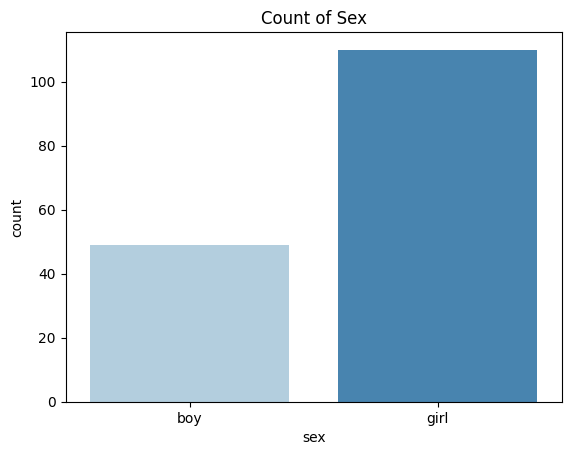

In [7]:
# # Ignore warnings
# warnings.filterwarnings("ignore")

# Count the occurrences of each category in the 'sex' column
target_count = df.sex.value_counts()

# Print the count of males
print('Boy:', target_count[1])

# Print the count of females
print('Girl:', target_count[0])

# Create a count plot of 'sex' with seaborn
sns.countplot(data=df, x="sex", hue="sex", palette="Blues")

# Set the title of the plot
plt.title('Count of Sex') 


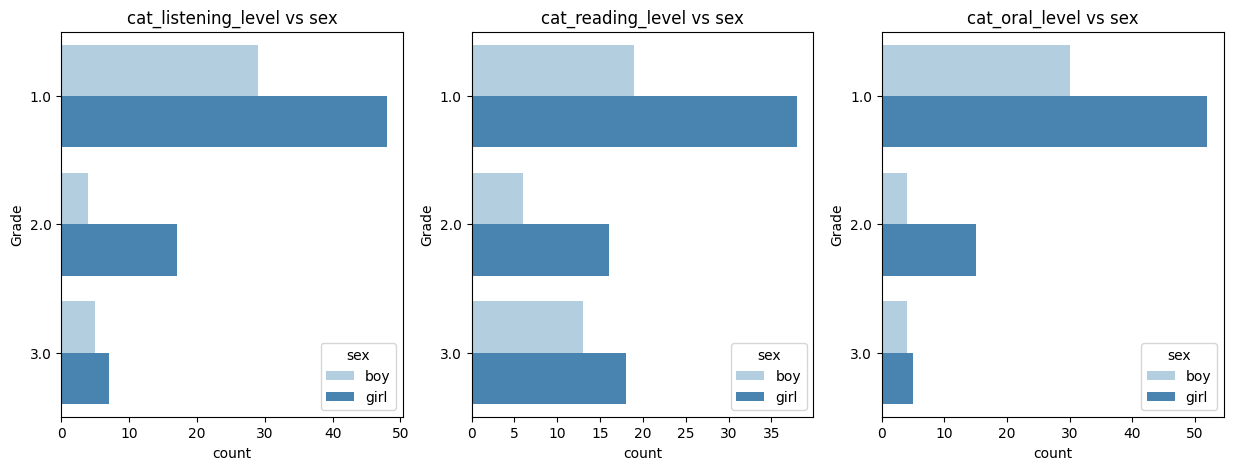

In [8]:
# 创建1行3列子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# 遍历三个CAT等级字段并绘制
for i, grade_period in enumerate(['cat_listening_level', 'cat_reading_level', 'cat_oral_level']):
    sns.countplot(ax=axes[i], data=df, y=grade_period, hue="sex", palette="Blues")
    axes[i].set_title(f'{grade_period} vs sex')
    axes[i].set_ylabel("Grade")

plt.show()


# Data Preprocessing

## new data items

- 是否具有last_n成绩：is_valid_last_n

- 倒数第n节课的发音/拼写/游戏成绩：last_n_fa/spell/game_score
  - 如果没有 last_n_xxx_score，使用 last_n-1_xxx_score 填充

- 倒数第n节课的成绩：last_n_grade = last_n_fa_score + last_n_spell_score + last_n_game_score
  - 如果没有last_n，使用 last_n-1 填充

- 年龄：age = now_time - birthday
  - 如果没有birthday，使用平均值填充

- 年龄的平方根：age_sqrt = np.sqrt(age)

- 当前课程的对数：lesson_id_log = np.log(lesson_id)

- 是否具有CAT成绩：is_valid_cat

- CAT听/说/读成绩：cat_listening/reading/oral_level
  - 如果没有 cat_listening/reading/oral_level，使用平均值填充

- CAT成绩：cat_grade = cat_listening_level + cat_reading_level + cat_oral_level
  - 如果没有CAT，使用平均值填充



In [9]:
import numpy as np
import datetime

# 1.1 是否具有last_n成绩
for n in [1, 2, 3]:
    df[f'is_valid_last_{n}'] = (~df[f'last_{n}_fa_score'].isna()) & \
                               (~df[f'last_{n}_spell_score'].isna()) & \
                               (~df[f'last_{n}_game_score'].isna())

# 1.2 last_n_xxx_score缺失时用last_n-1_xxx_score填充
for n in [1, 2, 3]:
    for score_type in ['fa_score', 'spell_score', 'game_score']:
        col = f'last_{n}_{score_type}'
        if n > 1:
            prev_col = f'last_{n-1}_{score_type}'
            # 用last_n-1_xxx_score填充last_n_xxx_score的缺失
            df[col] = df[col].fillna(df[prev_col])
        else:
            # 用主成绩列xxx_score填充last_1_xxx_score的缺失
            df[col] = df[col].fillna(df[score_type])

# 1.3 倒数第n节课的成绩
for n in [1, 2, 3]:
    # 先直接相加
    df[f'last_{n}_grade'] = df[f'last_{n}_fa_score'].fillna(0) + \
                      df[f'last_{n}_spell_score'].fillna(0) + \
                      df[f'last_{n}_game_score'].fillna(0)
    # 如果last_n为0（说明全是NaN），用last_n-1填充
    if n > 1:
        mask = (df[f'last_{n}_grade'] == 0)
        df.loc[mask, f'last_{n}_grade'] = df.loc[mask, f'last_{n-1}_grade']

# 2.1 年龄
now_time = pd.to_datetime('today')
df['birthday'] = pd.to_datetime(df['birthday'], errors='coerce')
df['age'] = (now_time - df['birthday']).dt.days / 365  # 保留小数
# 用平均年龄填充缺失
mean_age = df['age'].mean()
df['age'] = df['age'].fillna(mean_age)

# 2.2 年龄的平方根
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age_sqrt'] = np.sqrt(df['age'])

# 3.1 当前课程的对数
df['lesson_id'] = pd.to_numeric(df['lesson_id'], errors='coerce')
df['lesson_id_log'] = np.log1p(df['lesson_id'])

# 4.1 是否具有CAT成绩
df['is_valid_cat'] = (~df['cat_listening_level'].isna()) & \
                     (~df['cat_reading_level'].isna()) & \
                     (~df['cat_oral_level'].isna())

# 4.2 用平均值填充cat_listening/reading/oral_level的缺失
for col in ['cat_listening_level', 'cat_reading_level', 'cat_oral_level']:
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)

# 4.3 CAT成绩，用平均值填充缺失
df['cat_grade'] = df['cat_listening_level'].fillna(df['cat_listening_level'].mean()) + \
                  df['cat_reading_level'].fillna(df['cat_reading_level'].mean()) + \
                  df['cat_oral_level'].fillna(df['cat_oral_level'].mean())

## encode data items

In [10]:
# 参考上面数据内容，只有'sex'和'cat_listening_level'等为类别型，其他多为数值型
from sklearn.preprocessing import LabelEncoder

# 只对'sex'字段做LabelEncoder编码
if 'sex' in df.columns:
    le = LabelEncoder()
    df['sex'] = le.fit_transform(df['sex'])
    print(f"sex编码映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    # 例如: {'boy': 0, 'girl': 1}


sex编码映射: {'boy': 0, 'girl': 1}


## filter data

In [11]:
mask = (df['is_valid_last_1'] | df['is_valid_last_2'] | df['is_valid_last_3'] | df['is_valid_cat'])
df = df[mask].reset_index(drop=True)
print(f"清除所有历史成绩都为False的数据后，剩余{len(df)}条")

清除所有历史成绩都为False的数据后，剩余121条


## 查看数据项

In [12]:
print("📔 Data Info: ")
df.info()

with pd.option_context('display.max_columns', None):
    print("📔 Data Examples: ")
    display(df.head(5))

📔 Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   student_id           121 non-null    int64         
 1   lesson_id            121 non-null    int64         
 2   ts                   121 non-null    int64         
 3   spell_score          121 non-null    float64       
 4   fa_score             121 non-null    float64       
 5   game_score           121 non-null    float64       
 6   last_1_spell_score   121 non-null    float64       
 7   last_1_fa_score      121 non-null    float64       
 8   last_1_game_score    121 non-null    float64       
 9   last_2_spell_score   121 non-null    float64       
 10  last_2_fa_score      121 non-null    float64       
 11  last_2_game_score    121 non-null    float64       
 12  last_3_spell_score   121 non-null    float64       
 13  last_3_fa_score      

,student_id,lesson_id,ts,spell_score,fa_score,game_score,last_1_spell_score,last_1_fa_score,last_1_game_score,last_2_spell_score,last_2_fa_score,last_2_game_score,last_3_spell_score,last_3_fa_score,last_3_game_score,mobile,nickname,sex,birthday,cat_listening_level,cat_reading_level,cat_oral_level,is_valid_last_1,is_valid_last_2,is_valid_last_3,last_1_grade,last_2_grade,last_3_grade,age,age_sqrt,lesson_id_log,is_valid_cat,cat_grade
0,5611,2,1755015533,30.400000,18.263158,18.095238,30.400000,18.263158,18.095238,30.400000,18.263158,18.095238,30.400000,18.263158,18.095238,15711199244,157****9244,0,2018-01-01,1.000000,3.000000,3.000000,False,False,False,66.758396,66.758396,66.758396,7.643836,2.764749,1.098612,True,7.000000
1,5611,3,1754563774,2.750000,0.000000,0.000000,30.400000,18.263158,18.095238,30.400000,18.263158,18.095238,30.400000,18.263158,18.095238,15711199244,157****9244,0,2018-01-01,1.000000,3.000000,3.000000,True,False,False,66.758396,66.758396,66.758396,7.643836,2.764749,1.386294,True,7.000000
2,44395,10,1754908594,60.000000,26.052941,40.000000,60.000000,26.052941,40.000000,60.000000,26.052941,40.000000,60.000000,26.052941,40.000000,15127690367,151****0367,1,2016-02-07,1.409091,1.763636,1.336364,True,False,False,126.052941,126.052941,126.052941,9.545205,3.089532,2.397895,False,4.509091
3,44395,11,1755080900,50.333333,27.614286,33.939394,50.333333,27.614286,33.939394,60.000000,26.052941,40.000000,60.000000,26.052941,40.000000,15127690367,151****0367,1,2016-02-07,1.409091,1.763636,1.336364,True,True,False,111.887013,126.052941,126.052941,9.545205,3.089532,2.484907,False,4.509091
4,42476,2,1754564107,15.014286,2.281081,20.000000,15.014286,2.281081,20.000000,15.014286,2.281081,20.000000,15.014286,2.281081,20.000000,13927154618,139****4618,0,2018-01-28,3.000000,3.000000,3.000000,False,False,False,37.295367,37.295367,37.295367,7.569863,2.751338,1.098612,True,9.000000


## 可视化分析数据项

Text(0.5, 1.0, 'Correlation Heatmap')

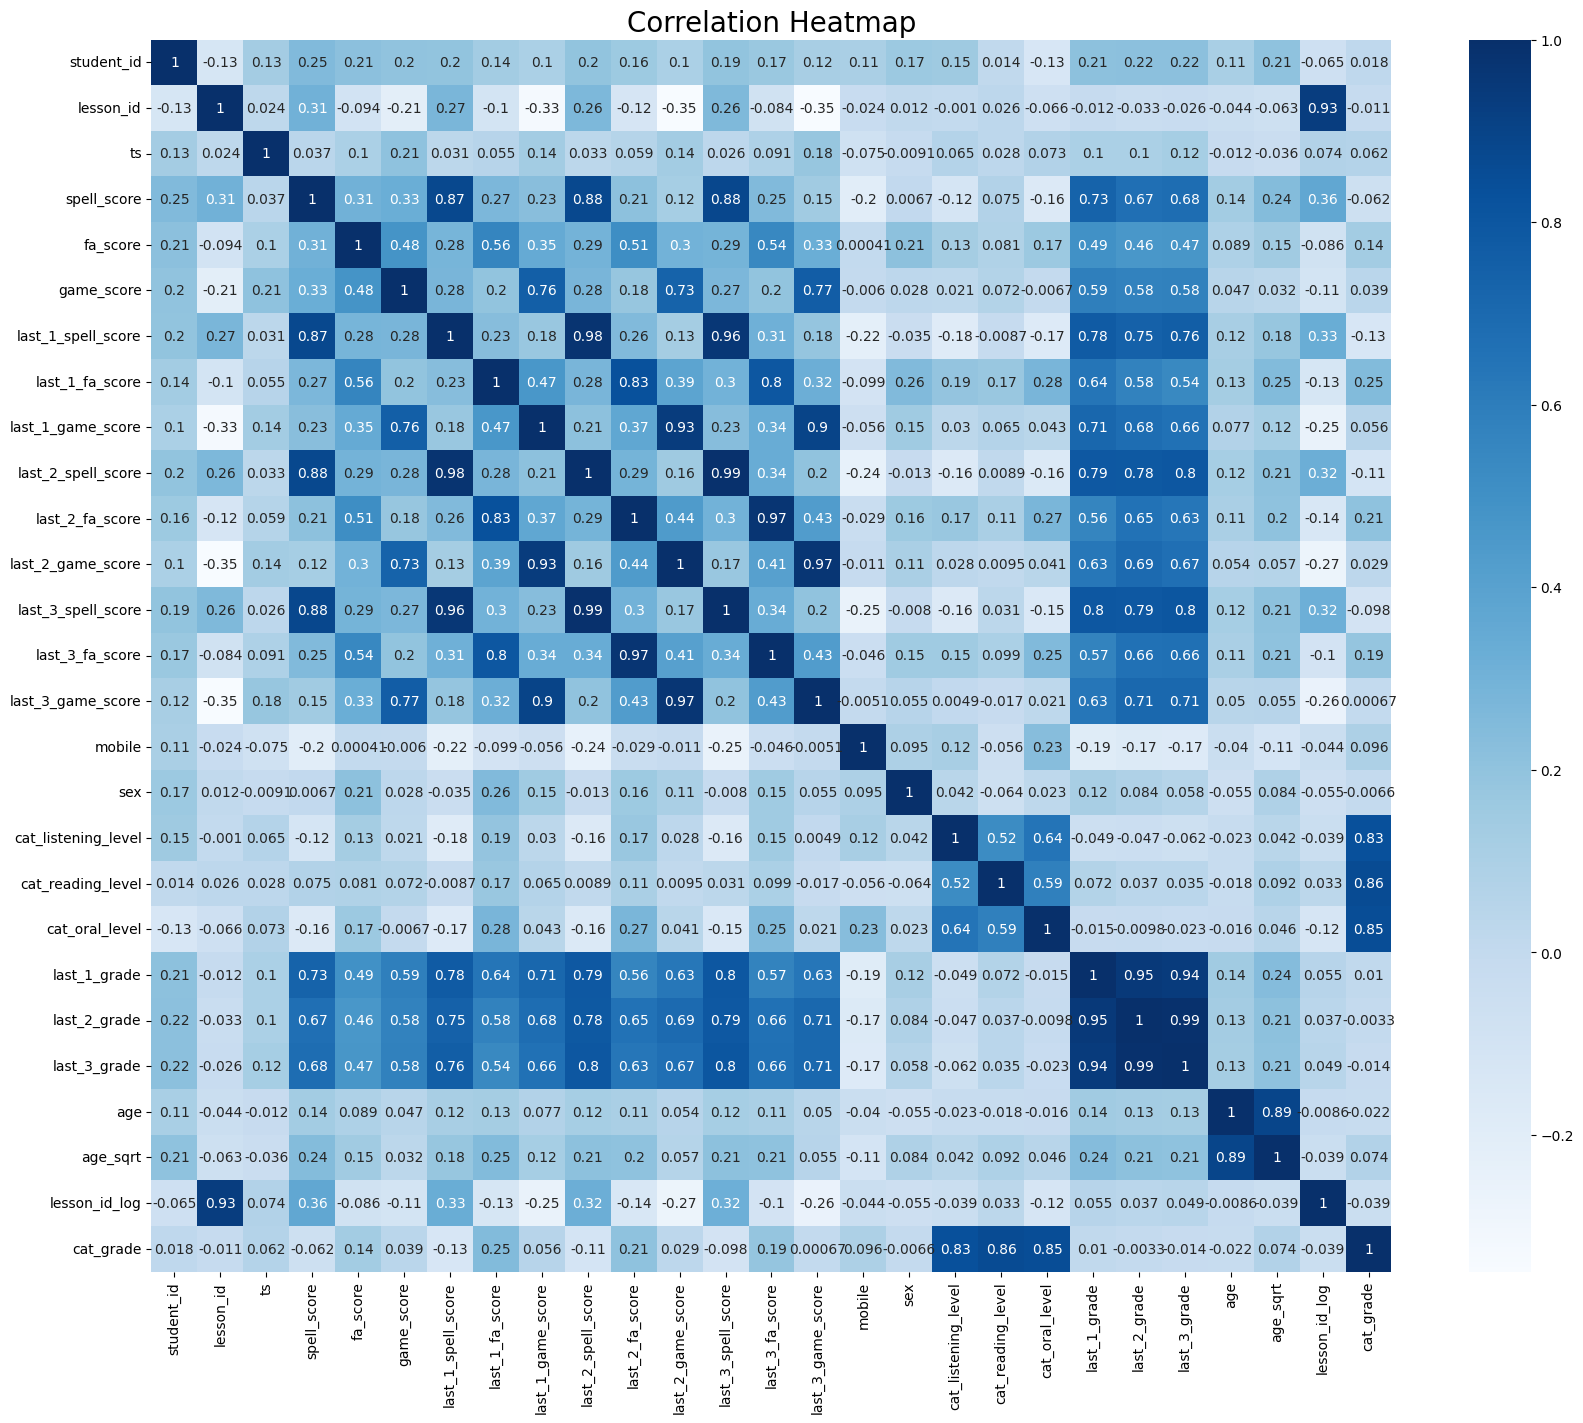

In [13]:
# Calculate the correlation matrix
# 排除非数值型字段（如手机号、昵称等），避免相关性计算报错
corr = df.select_dtypes(include=[np.number]).corr()

# Create a figure with a large size
# plt.figure(figsize=(50,50))
plt.figure(figsize=(20, 16))  # 调整为更合适的大小

# Plot the heatmap using seaborn, with annotations and a blue colormap
sns.heatmap(corr, annot=True, cmap="Blues")

# Set the title of the plot
plt.title('Correlation Heatmap', fontsize=20)


<Axes: xlabel='spell_score'>

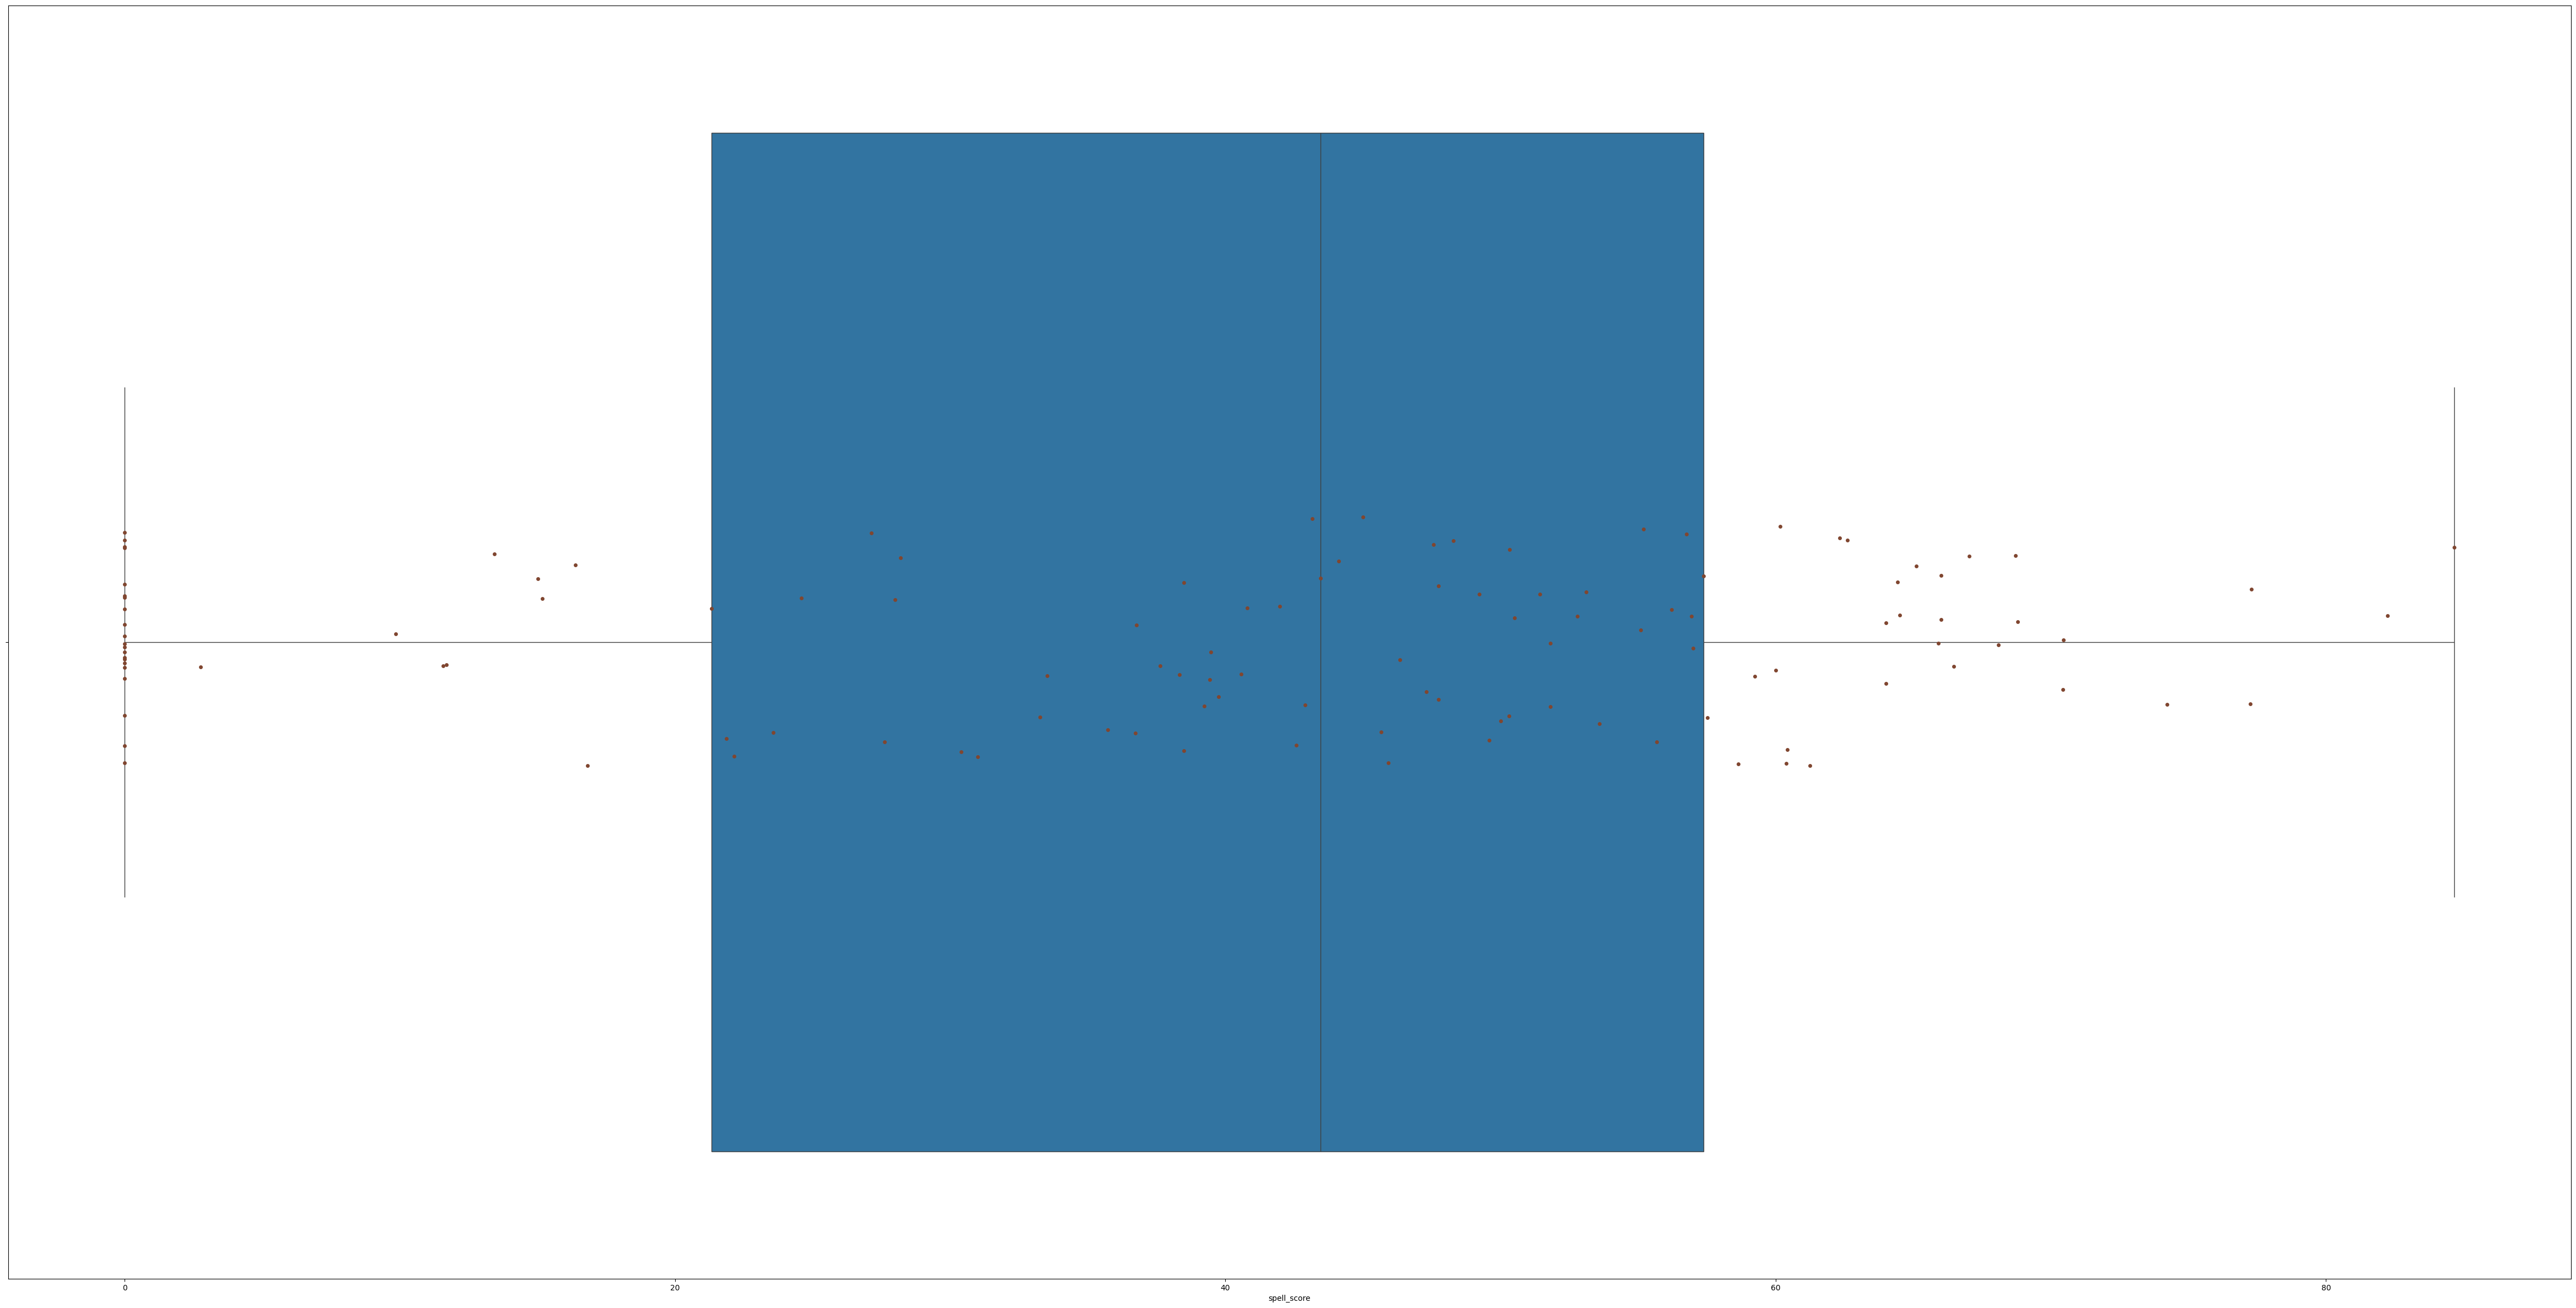

In [14]:
# cheaking the outliers in the feature 'G1'
plt.figure(figsize = (60,30))
sns.boxplot(x='spell_score', data=df)
sns.stripplot(x='spell_score', data=df, color="#804630")

# Feature Selection

In [15]:
# todo

feat = [
    'last_1_spell_score', 'last_1_fa_score', 'last_1_game_score', 'last_1_grade', 'is_valid_last_1', 
    'last_2_spell_score', 'last_2_fa_score', 'last_2_game_score', 'last_2_grade', 'is_valid_last_2', 
    'last_3_spell_score', 'last_3_fa_score', 'last_3_game_score', 'last_3_grade', 'is_valid_last_3', 
    'cat_listening_level', 'cat_reading_level', 'cat_oral_level', 'cat_grade', 'is_valid_cat',    
    'sex', 'age', 'lesson_id' # , 'age_sqrt', 'lesson_id_log'
]

# Model and Optimaization

### Summary

| 模型 | MSE | RMSE | R^2 |
| --- | --- | --- | --- |
| Linear Regression (baseline) | 91 | 9.55 | 0.83 |
| Decision Tree Regression | 84 | 9.15 | 0.85 |
| Random Forest Regression | 74 | 8.62 | 0.86 |
| Support Vector Machine Regression (SVR) | 63 | 7.92 | 0.89 |
| XGBoost Regression | 70 | 8.38 | 0.87 |
| K Nearest Neighbors Regression (KNNR) | 90 | 9.48 | 0.84 |
| MLP (神经网络) | 98 | 9.89 | 0.82 |

- **MSE（均方误差）**：反映预测值与真实值之间的平均平方差，数值越小表示模型预测越准确。
- **RMSE（均方根误差）**：MSE的平方根，和原始数据量纲一致，更直观地衡量预测误差的大小，越小越好。
- **R²（决定系数）**：衡量模型对数据的拟合优度，取值范围0~1，越接近1说明模型解释能力越强。



| 模型                                          | 优点                               | 缺点                           | 在你数据集的适用性                        |
| ------------------------------------------- | -------------------------------- | ---------------------------- | -------------------------------- |
| **Linear Regression**                       | 简单、计算快、结果可解释性强                   | 只能拟合线性关系；缺失值要补齐；容易欠拟合        | **可做Baseline**，快速验证数据质量          |
| **Decision Tree Regression**                | 能处理非线性关系；对缺失值相对不敏感（部分实现支持）；可解释性强 | 容易过拟合，单树泛化能力弱                | 样本小的情况下可用，但结果可能不稳定               |
| **Random Forest Regression**                | 集成学习，稳定性好；能自动评估特征重要性；对缺失值较鲁棒     | 样本太小（150条）时，容易过拟合或不稳定        | 样本太少时效果未必比单棵树好                   |
| **Support Vector Machine Regression (SVR)** | 在小样本场景下常常表现好；能捕捉复杂模式             | 对缺失值敏感；需要特征缩放；参数调优麻烦         | **很适合150条这种小数据集**，但要注意缺失值处理和参数调优 |
| **XGBoost Regression**                      | 表现强大；能处理缺失值（内置机制）；非线性拟合能力强       | 样本太小容易过拟合；参数调优复杂             | 样本量不足时可能不如SVR/树简单                |
| **K Nearest Neighbors Regression (KNNR)**   | 原理简单；能捕捉局部模式                     | 对缺失值非常敏感；维度高、样本少时容易退化；预测时开销大 | **不太适合你的数据（样本小+缺失多）**            |
| **MLP (神经网络)**                              | 能学习复杂非线性关系                       | 样本太少，极易过拟合；缺失值要处理；需要GPU      | **基本不推荐150条数据用MLP**              |


### Linear Regression model

作为 baseline

In [16]:
# Linear Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Linear Regression with specified parameters
LR = LinearRegression(fit_intercept= True ,n_jobs = 1)

# Train the regression
LR.fit(X_train, y_train)

# Predict on the testing data
y_pred = LR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

# MSE：均方误差，衡量预测值与真实值的平均平方差，越小越好
print("LR Mean Squared Error MSE:", mse)
# RMSE：均方根误差，MSE的平方根，和原始数据量纲一致，越小越好
print("LR Root Mean Squared Error RMSE:", rmse)
# R^2：决定系数，衡量模型拟合优度，1为完美拟合，0为无解释力
print("LR R^2 Score:", r2)

LR Mean Squared Error MSE: 91.15375034397131
LR Root Mean Squared Error RMSE: 9.547447320827244
LR R^2 Score: 0.8335305056295181


In [17]:
# using Gridsearch for best performancing Linear Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV

param_grid = {'fit_intercept': [True, False],
              'n_jobs' : [1, -1]}
grid = GridSearchCV(LinearRegression(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

{'fit_intercept': False, 'n_jobs': 1}

In [18]:
grid.best_estimator_

,fit_intercept,False
,copy_X,True
,tol,1e-06
,n_jobs,1
,positive,False


In [19]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized LR Mean Squared Error MSE:", mse)
print("Optimaized LR Root Mean Squared Error RMSE:", rmse)
print("Optimaized LR R^2 Score:", r2)

Optimaized LR Mean Squared Error MSE: 91.38849560899521
Optimaized LR Root Mean Squared Error RMSE: 9.559733030215604
Optimaized LR R^2 Score: 0.8331018021979322


In [20]:
# Get the list of available parameters in Linear Regression model
parameters = LinearRegression().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'positive', 'tol'])


### Decision Tree Regression model

In [21]:
# Decision Tree Regression model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regression with specified parameters
DTR = DecisionTreeRegressor(random_state=100, criterion='squared_error', max_depth=30, min_samples_leaf=5)

# Train the regression
DTR.fit(X_train, y_train)

# Predict on the testing data
y_pred = DTR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("DTR Mean Squared Error MSE:", mse)
print("DTR Root Mean Squared Error RMSE:", rmse)
print("DTR R^2 Score:", r2)

DTR Mean Squared Error MSE: 141.62707170059429
DTR Root Mean Squared Error RMSE: 11.900717276727242
DTR R^2 Score: 0.7413536258661549


In [ ]:
# using Gridsearch for best performancing Decision Tree Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 31))
param_grid = {'random_state': number,
              'criterion' : ["squared_error", "absolute_error", "friedman_mse", "poisson"],
              'max_depth' : numbers,
              'min_samples_leaf' :  numbers}
grid = GridSearchCV(DecisionTreeRegressor(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

In [ ]:
grid.best_estimator_

,criterion,'absolute_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized DTR Mean Squared Error MSE:", mse)
print("Optimaized DTR Root Mean Squared Error RMSE:", rmse)
print("Optimaized DTR R^2 Score:", r2)

Optimaized DTR Mean Squared Error MSE: 83.70071013776611
Optimaized DTR Root Mean Squared Error RMSE: 9.148809219661656
Optimaized DTR R^2 Score: 0.8471416168560779


In [ ]:
# Get the list of available parameters in Decision Tree Regression model
parameters = DecisionTreeRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])


### Random Forest Regression model

In [ ]:
# Random Forest Regression model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Random Forest Regression with specified parameters
RFR = RandomForestRegressor(random_state=100, criterion='squared_error', max_depth=30, min_samples_leaf=5, n_jobs=1)

# Train the regression
RFR.fit(X_train, y_train)

# Predict on the testing data
y_pred = RFR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("RFR Mean Squared Error MSE:", mse)
print("RFR Root Mean Squared Error RMSE:", rmse)
print("RFR R^2 Score:", r2)

RFR Mean Squared Error MSE: 93.41288925369255
RFR Root Mean Squared Error RMSE: 9.66503436381333
RFR R^2 Score: 0.8294047542413983


In [ ]:
# using Gridsearch for best performancing Random Forest Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 31))
param_grid = {'criterion': ["squared_error", "absolute_error"],
              'random_state' : number,
              'n_jobs' : [1, -1],
              'max_depth' :  numbers}
grid = GridSearchCV(RandomForestRegressor(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 2,
 'n_jobs': 1,
 'random_state': 11}

In [ ]:
grid.best_estimator_

,n_estimators,100
,criterion,'absolute_error'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized RFR Mean Squared Error MSE:", mse)
print("Optimaized RFR Root Mean Squared Error RMSE:", rmse)
print("Optimaized RFR R^2 Score:", r2)

Optimaized RFR Mean Squared Error MSE: 74.25077527056014
Optimaized RFR Root Mean Squared Error RMSE: 8.616888955450229
Optimaized RFR R^2 Score: 0.864399556032925


In [ ]:
# Get the list of available parameters in Random Forest Regression model
parameters = RandomForestRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


### Support Vector Machine Regression model

In [ ]:
# Support Vector Machine Regression model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Support Vector Machine Regression  with specified parameters
SVMR = SVR(kernel ='poly')

# Train the regression
SVMR.fit(X_train, y_train)

# Predict on the testing data
y_pred = SVMR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)


print("SVMR Mean Squared Error MSE:", mse)
print("SVMR Root Mean Squared Error RMSE:", rmse)
print("SVMR R^2 Score:", r2)

SVMR Mean Squared Error MSE: 242.8337574817872
SVMR Root Mean Squared Error RMSE: 15.583124124571016
SVMR R^2 Score: 0.5565249628069647


In [ ]:
# using Gridsearch for best performancing Support Vector Machine Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 11))
param_grid = {'gamma' : ['scale', 'auto'],
              'kernel' : ['linear', 'rbf', 'sigmoid'],
              'degree' :  numbers}
grid = GridSearchCV(SVR(),param_grid,refit=True, verbose=3, cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END degree=1, gamma=scale, kernel=linear;, score=0.913 total time=   0.2s
[CV 2/5] END degree=1, gamma=scale, kernel=linear;, score=0.880 total time=   0.4s
[CV 3/5] END degree=1, gamma=scale, kernel=linear;, score=0.657 total time=   0.3s
[CV 4/5] END degree=1, gamma=scale, kernel=linear;, score=0.394 total time=   0.8s
[CV 5/5] END degree=1, gamma=scale, kernel=linear;, score=0.775 total time=   0.2s
[CV 1/5] END .degree=1, gamma=scale, kernel=rbf;, score=0.430 total time=   0.0s
[CV 2/5] END .degree=1, gamma=scale, kernel=rbf;, score=0.416 total time=   0.0s
[CV 3/5] END .degree=1, gamma=scale, kernel=rbf;, score=0.462 total time=   0.0s
[CV 4/5] END .degree=1, gamma=scale, kernel=rbf;, score=0.352 total time=   0.0s
[CV 5/5] END .degree=1, gamma=scale, kernel=rbf;, score=0.384 total time=   0.0s
[CV 1/5] END degree=1, gamma=scale, kernel=sigmoid;, score=0.136 total time=   0.0s
[CV 2/5] END degree=1, gamma=scale

{'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
grid.best_estimator_

,kernel,'linear'
,degree,1
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized SVMR Mean Squared Error MSE:", mse)
print("Optimaized SVMR Root Mean Squared Error RMSE:", rmse)
print("Optimaized SVMR R^2 Score:", r2)

Optimaized SVMR Mean Squared Error MSE: 62.74347154375631
Optimaized SVMR Root Mean Squared Error RMSE: 7.921077675654765
Optimaized SVMR R^2 Score: 0.8854147641372538


In [ ]:
# Get the list of available parameters in Support Vector Machine Regression model
parameters = SVR().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])


### XGBoost Regression model

In [ ]:
# XGBoost Regression model
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the XGBoost Regression with specified parameters
XGBR = XGBRegressor(gamma= 0.3, random_state= 42, n_estimators=11, n_jobs= -1, max_depth=10)

# Train the regression
XGBR.fit(X_train, y_train)

# Predict on the testing data
y_pred = XGBR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("XGBR Mean Squared Error MSE:", mse)
print("XGBR Root Mean Squared Error RMSE:", rmse)
print("XGBR R^2 Score:", r2)

XGBR Mean Squared Error MSE: 70.25696707745959
XGBR Root Mean Squared Error RMSE: 8.38194291781205
XGBR R^2 Score: 0.8716932463968357


In [ ]:
# using Gridsearch for best performancing XGBoost Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 11))
param_grid = {'random_state' : number,
              'n_estimators' : numbers,
              'n_jobs' :  [1, -1],
              'max_depth': numbers}
param_grid = {
    'n_estimators': [8, 10, 11, 12, 15, 20],        # 围绕初始最优值11搜索
    'max_depth': [8, 9, 10, 11, 12],                # 围绕初始最优值10搜索  
    'learning_rate': [0.1, 0.2, 0.3, 0.4],        
    'gamma': [0.2, 0.3, 0.4, 0.5],                  # 围绕初始有效值0.3搜索
    'random_state': number,                         # 固定随机种子，不作为优化目标
    'n_jobs': [-1]                                  # 固定多线程，不作为优化目标
}
grid = GridSearchCV(XGBRegressor(), param_grid, cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 20,
 'n_jobs': -1,
 'random_state': 5}

In [ ]:
grid.best_estimator_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized XGBR Mean Squared Error MSE:", mse)
print("Optimaized XGBR Root Mean Squared Error RMSE:", rmse)
print("Optimaized XGBR R^2 Score:", r2)

Optimaized XGBR Mean Squared Error MSE: 72.65445153118006
Optimaized XGBR Root Mean Squared Error RMSE: 8.523758063857752
Optimaized XGBR R^2 Score: 0.8673148415230274


In [ ]:
# Get the list of available parameters in XGBoost Regression model
parameters = XGBRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'multi_strategy', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])


### K Nearest Neighbors Regression model


In [ ]:
# K Nearest Neighbors Regression model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the K Nearest Neighbors Regression model with specified parameters
KNNR = KNeighborsRegressor(n_neighbors= 7, n_jobs= 1, metric= 'manhattan')

# Train the regression
KNNR.fit(X_train, y_train)

# Predict on the testing data
y_pred = KNNR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("KNNR Mean Squared Error MSE:", mse)
print("KNNR Root Mean Squared Error RMSE:", rmse)
print("KNNR R^2 Score:", r2)

KNNR Mean Squared Error MSE: 115.45250590418676
KNNR Root Mean Squared Error RMSE: 10.744882777591702
KNNR R^2 Score: 0.7891549145356018


In [ ]:
# using Gridsearch for best performancing K Nearest Neighbors Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 51))
param_grid = {'n_neighbors': number,
              'n_jobs' :  [1, -1],
              'metric' : ['manhattan','euclidean','minkowski']}
grid = GridSearchCV(KNeighborsRegressor(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

/opt/anaconda3/envs/myd2l/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/myd2l/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/anaconda3/envs/myd2l/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 492, in __call__
    return estimator.score(*args, **kwargs)
  File "/opt/anaconda3/envs/myd2l/lib/python3.10/site-packages/sklearn/base.py", line 638, in score
    y_pred = self.predict(X)
  File "/opt/anaconda3/envs/myd2l/lib/python3.10/site-packages/sklearn/neighbors/_regression.py", line 243, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/opt/anaconda3/envs/myd2l/lib/python3.10/site-packages/sklearn/neighbors/_base.py", line

{'metric': 'manhattan', 'n_jobs': 1, 'n_neighbors': 13}

In [ ]:
grid.best_estimator_

,n_neighbors,13
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'manhattan'
,metric_params,None
,n_jobs,1


In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized KNNR Mean Squared Error MSE:", mse)
print("Optimaized KNNR Root Mean Squared Error RMSE:", rmse)
print("Optimaized KNNR R^2 Score:", r2)

Optimaized KNNR Mean Squared Error MSE: 89.91205252365118
Optimaized KNNR Root Mean Squared Error RMSE: 9.482196608573943
Optimaized KNNR R^2 Score: 0.8357981556990941


In [ ]:
# Get the list of available parameters in K Nearest Neighbors Regression model
parameters = KNeighborsRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])


### MLP —— MultiLayer Perceptron

In [23]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
# 使用DataLoader实现小批次训练
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# 1. 预处理数据
# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

X = features.values
y = target.values

# 标准化特征
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# 转为Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 2. 定义改进的MLP模型
class MLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # 第一隐藏层：适度增加神经元数量
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),      # 批归一化稳定训练
            nn.ReLU(),
            nn.Dropout(dropout_rate), # Dropout防止过拟合
            
            # 第二隐藏层
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),        # LeakyReLU避免死神经元
            nn.Dropout(dropout_rate),
            
            # 第三隐藏层
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2), # 递减Dropout率
            
            # 输出层
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])

# 3. 训练模型
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 400

# 构建TensorDataset
train_dataset = TensorDataset(X_train, y_train)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("开始训练PyTorch MLP模型...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    # 使用DataLoader进行小批次训练
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # 计算平均损失
    avg_loss = epoch_loss / len(train_loader)
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

print("训练完成！")

# 4. 测试集评估
model.eval()
with torch.no_grad():
    pred = model(X_test)
    test_loss = criterion(pred, y_test)
    print(f"Test MSE: {test_loss.item():.4f}")

# 4. 测试集评估
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    
    # 转换回numpy并反标准化
    y_pred_scaled = y_pred_tensor.numpy().flatten()
    y_test_scaled = y_test.numpy().flatten()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# 计算评估指标
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)

print("\n=== PyTorch MLP 模型评估结果 ===")
print("MLPR Mean Squared Error MSE:", mse)
print("MLPR Root Mean Squared Error RMSE:", rmse)
print("MLPR R^2 Score:", r2)


开始训练PyTorch MLP模型...
Epoch 50/400, Loss: 0.2180
Epoch 100/400, Loss: 0.1734
Epoch 150/400, Loss: 0.1259
Epoch 200/400, Loss: 0.1490
Epoch 250/400, Loss: 0.1626
Epoch 300/400, Loss: 0.1441
Epoch 350/400, Loss: 0.1144
Epoch 400/400, Loss: 0.0998
训练完成！
Test MSE: 0.1702

=== PyTorch MLP 模型评估结果 ===
MLPR Mean Squared Error MSE: 97.8365707397461
MLPR Root Mean Squared Error RMSE: 9.891237068220844
MLPR R^2 Score: 0.8213260173797607
